## Model regression

As a previous step to start exploring models, cleaned data is load and separated into train and test sets.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load cleaned data
df = pd.read_pickle("../data/clean.pkl")
X = df.drop('fare', axis=1)
y = df["fare"]
y = np.asarray(y, dtype=np.float64)

# Generate sets: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Model building

## Score function

A score function is needed to compare different models. Because in this case I'm going to use a common error function (MSE) which is included in sklearn metrics and most of the models, I don't need to define it explicitly. A helper function is implemented to calculate the scores given a model.

As a baseline for the model performance a dummy model which return the mean is created.

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Given a model calculate the train and test scores
def get_scores(est):
    y_train_predict = est.predict(X_train)
    train_predict = mean_squared_error(y_train, y_train_predict)
    y_test_predict = est.predict(X_test)
    test_predict = mean_squared_error(y_test, y_test_predict)
    print("Train mse:", train_predict, "; Test mse:", test_predict)
    return (train_predict, test_predict)

# Given a model plot the residual plot for the test dataset
def plot_residuals(est):
    sns.residplot(est.predict(X_test), y_test)

# Dummy model generation and score
dummyModel = DummyRegressor(strategy="mean")
dummyModel.fit(X_train, y_train)
get_scores(dummyModel)

Train mse: 139.25931558189907 ; Test mse: 140.00158912997748


(139.25931558189907, 140.00158912997748)

The dummy model achieved a train score of 140.

## Support Vector Machine

```python
from sklearn import svm
est_svm = svm.SVR(cache_size=13000)
# Train and score model
est_svm = est_svm.fit(X_train, y_train)
get_scores(est_svm)
plot_residuals(est_svm)
```
Too slow for this dataset, stopped after 20 minutes with plenty of available memory.

## Decision Tree

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  1.7min finished


Train mse: 8.760664924502084 ; Test mse: 9.646591945480552


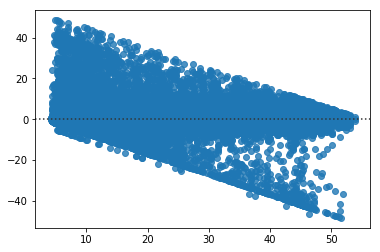

In [4]:
from sklearn import tree

# Parameters to tune
parameters = {'min_samples_split':[2, 4, 16, 64, 128, 256, 1024],
              'min_samples_leaf':[1, 2, 4, 16, 64, 128, 256, 1024]}

# Declare objects
est_dt_r = tree.DecisionTreeRegressor()
est_dt = GridSearchCV(est_dt_r, parameters, n_jobs=-1, cv=5, verbose=1)
# Train and score model
est_dt = est_dt.fit(X_train, y_train)
get_scores(est_dt)
plot_residuals(est_dt)

In [7]:
# Print best parameters found by the grid search
est_dt.best_params_

{'min_samples_leaf': 4, 'min_samples_split': 128}

For a first model and a basic grid search the results are quite good.

Looking at the residuals plot we see a clear lineal trend that will appear on almost all the models. This can mean that we missed some important explanatory variable, which is normal, since we have restricted the set to a limited subset of variables.

## Gaussian Process Regression

```python
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import gaussian_process
# Declare objects
kernel = gaussian_process.kernels.RBF(50., (50., 50.))
est_gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel, random_state=1773)
# Train and score model
est_gpr = est_gpr.fit(X_train, y_train)
get_scores(est_gpr)
plot_residuals(est_gpr)
```

Even with 32G of ram it's not enough to fit this dataset. This model is discard.

## Stochastic Gradient Descent

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  1.9min remaining:   48.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


Train mse: 9.53397586022029e+25 ; Test mse: 9.5118561056771e+25


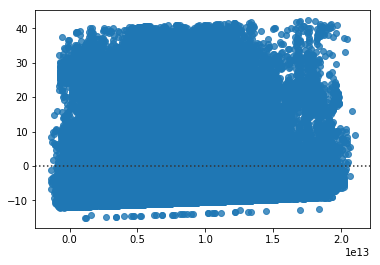

In [8]:
from sklearn.linear_model import SGDRegressor

# Parameters to tune
parameters = {'alpha':[0.0001, 0.001, 0.00001],
              'learning_rate':["optimal", "invscaling"]}

# Declare objects
est_nn_r = SGDRegressor(max_iter=10000, tol=1e-3)
est_nn = GridSearchCV(est_nn_r, parameters, n_jobs=-1, cv=5, verbose=1)
# Train and score model
est_nn = est_nn.fit(X_train, y_train)
get_scores(est_nn)
plot_residuals(est_nn)

That is a very bad model, order of magnitude worse than the dummy one.

## Ensemble methods
Ensamble methods use different models to obtain a better one. Usually active better results and less overfitting, so I'm expecting to active better results than to the previous ones.
### Random forest

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 46.3min finished


Train mse: 8.2966171095316 ; Test mse: 9.314486250959263


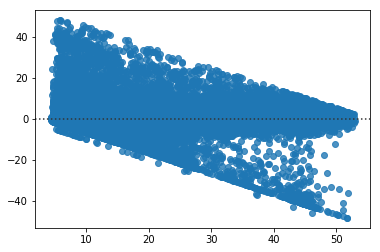

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Parameters to tune
parameters = {'n_estimators':[10, 50, 100, 150],
              'min_samples_split':[64, 128, 256],
              'min_samples_leaf': [2, 4, 6]}

# Declare objects
est_rf_r = RandomForestRegressor(random_state=1337)
est_rf = GridSearchCV(est_rf_r, parameters, cv=4, verbose=1, n_jobs=-1)
# Train and score model
est_rf = est_rf.fit(X_train, y_train)
get_scores(est_rf)
plot_residuals(est_rf)

In [10]:
# Print best parameters found by the grid search
est_rf.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 64, 'n_estimators': 150}

Random forest is just a combination of smaller decisions trees than then vote. I was expecting to improve respect the single decision tree model, but the results are almost identical.

### Ada boost

Fitting 4 folds for each of 18 candidates, totalling 72 fits


/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.2min finished


Train mse: 29.84582500260886 ; Test mse: 30.024516886239947


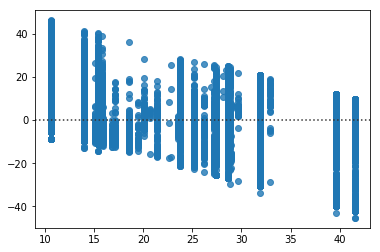

In [3]:
from sklearn.ensemble import AdaBoostRegressor

# Parameters to tune
parameters = {'n_estimators':[25, 50, 100],
              'loss':["square", "linear"],
              'learning_rate': [0.75, 1, 1.25]}

# Declare objects
est_ada_r = AdaBoostRegressor(random_state=1337)
est_ada = GridSearchCV(est_ada_r, parameters, cv=4, verbose=1, n_jobs=-1)
# Train and score model
est_ada = est_ada.fit(X_train, y_train)
get_scores(est_ada)
plot_residuals(est_ada)

In [4]:
# Print best parameters found by the grid search
est_ada.best_params_

{'learning_rate': 1.25, 'loss': 'linear', 'n_estimators': 25}

This is the first time the residual analysis have a significative change. Despite this model is not bad, it's far from the best at the moment.

### Gradient Tree Boosting

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 17.4min finished


Train mse: 14.911444949138414 ; Test mse: 15.006174313223534


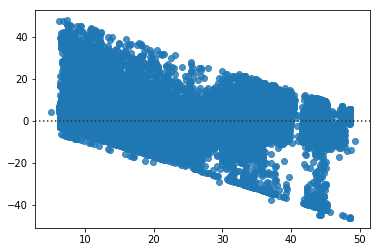

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

# Parameters to tune
parameters = {'n_estimators':[50, 100, 150],
              'min_samples_split':[64, 128, 256],
              'min_samples_leaf': [2, 4, 6]}

# Declare objects
est_gtb_r = GradientBoostingRegressor(loss='ls')
est_gtb = GridSearchCV(est_gtb_r, parameters, cv=4, verbose=1, n_jobs=-1)
# Train and score model
est_gtb = est_gtb.fit(X_train, y_train)
get_scores(est_gtb)
plot_residuals(est_gtb)
# Print best parameters found by the grid search
print(est_gtb.best_params_)

That's quite a good model, but doubles the error compared with the decision tree.

## Neural network model

As a difference with the previous models, the data have been scaled due to the sensitivity of the algorithm to this matter.

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Fit and transform the scaler with the train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Define and train the model
est_net = MLPRegressor(learning_rate="adaptive", max_iter=400, hidden_layer_sizes=(150, ))
est_net = est_net.fit(X_train_s, y_train)

Train mse: 13.89962605928484 ; Validation mse: 14.04783969813956


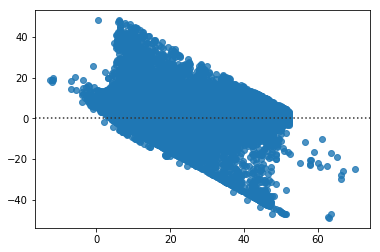

In [4]:
# Escale the test data and generate benchmark
y_train_predict = est_net.predict(X_train_s)
train_predict = mean_squared_error(y_train, y_train_predict)
y_test_predict = est_net.predict(X_test_s)
test_predict = mean_squared_error(y_test, y_test_predict)
print("Train mse:", train_predict, "; Validation mse:", test_predict)

sns.residplot(est_net.predict(X_test_s), y_test);

Although here only appears a single model, I have tried changing some parameters to try to improve the results, with not much difference.

This fit into the good models, but still far from the decision trees.

# Optimization

The best two models generated so far are the **Decision Tree** and ** the **Random forest**. Let's try to further tune its parameters before make the final selection.

## Decision Tree

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   37.9s finished


Train mse: 8.852923740759808 ; Test mse: 9.640593172582795


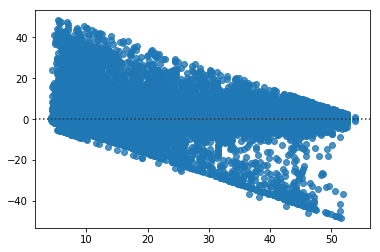

In [32]:
from sklearn import tree

# Parameters to tune
parameters = {'min_samples_split':[130, 140, 150],
              'min_samples_leaf':[7, 8, 9],
              'max_depth':[None, 180, 220]}

# Declare objects
est_dt_r = tree.DecisionTreeRegressor(random_state=1773)
est_dt = GridSearchCV(est_dt_r, parameters, n_jobs=-1, cv=5, verbose=1)
# Train and score model
est_dt = est_dt.fit(X_train, y_train)
get_scores(est_dt)
plot_residuals(est_dt)

In [33]:
# Print best parameters found by the grid search
est_dt.best_params_

{'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 140}

Surprisingly, the test score is the same of the first grid search, **9.64**.

## Random forest

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 33.7min remaining: 14.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.5min finished


Train mse: 8.210742279199545 ; Test mse: 9.314832623874496


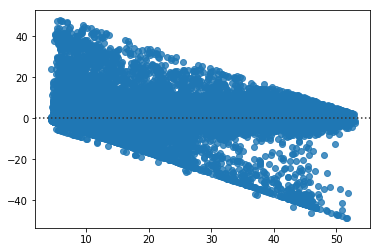

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Parameters to tune
parameters = {'n_estimators':[200, 300],
              'min_samples_split':[30, 60, 90],
              }

# Declare objects
est_rf_r = RandomForestRegressor(random_state=1337)
est_rf = GridSearchCV(est_rf_r, parameters, cv=5, verbose=1, n_jobs=-1)  
# Train and score model
est_rf = est_rf.fit(X_train, y_train)
get_scores(est_rf)
plot_residuals(est_rf)

In [15]:
# Print best parameters found by the grid search
est_rf.best_params_

{'min_samples_split': 60, 'n_estimators': 300}

Train mse: 8.254857401776876 ; Test mse: 9.316405412928338


Like the other case, test score is the same of the first grid search, **9.31**.

# Final model selecction

Random forest is selected as the final model. Let's make more plots to ensure analize the quality of the solution.

Train mse: 8.210742279199545 ; Test mse: 9.314756972477982


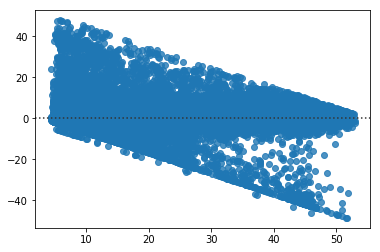

In [13]:
from sklearn.ensemble import RandomForestRegressor
est = RandomForestRegressor(random_state=1337, min_samples_split=60, n_estimators=300, n_jobs=-1)              
est = est.fit(X_train, y_train)
get_scores(est)
plot_residuals(est)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_test_predict = est.predict(X_test)

mae = mean_absolute_error(y_test, y_test_predict)
mse = mean_squared_error(y_test, y_test_predict)
r_2 = r2_score(y_test, y_test_predict)
print("MSE -> ", mse)
print("MAE -> ", mae)
print("R^2 -> ", r_2)

MSE ->  9.314756972477982
MAE ->  1.5465034103726478
R^2 ->  0.933466307561008


# Generate extra graphics for the documentation

In [15]:
import numpy as np
from sklearn.decomposition import PCA

# Fit the test data into a PCA and get the principal component
pca = PCA(n_components=2)
new_x = pca.fit_transform(X_test)

/home/alejandro/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


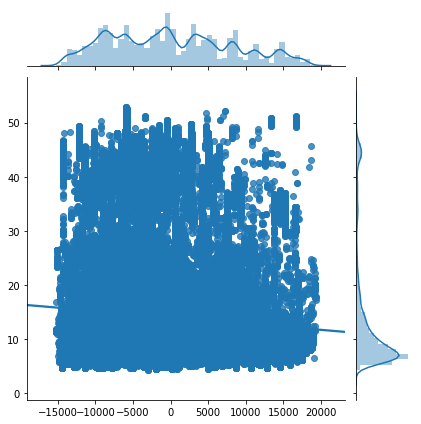

In [16]:
# Plot predicted fare and first component to try to observe a relation
sns.jointplot(x=new_x[:, 0], y=y_test_predict, kind="reg");